In [100]:
import warnings
warnings.filterwarnings('ignore')

import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import cv2
import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [2]:
DIR = os.listdir('tomatoleaf/tomato/train')

In [3]:
print(DIR)

['Tomato___Late_blight', 'Tomato___healthy', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Leaf_Mold', 'Tomato___Spider_mites Two-spotted_spider_mite']


In [4]:
labels = ['Tomato___Late_blight', 'Tomato___healthy', 'Tomato___Early_blight', 
          'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 
          'Tomato___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 
          'Tomato___Leaf_Mold', 'Tomato___Spider_mites Two-spotted_spider_mite']

In [5]:
img_size = (224, 224)

In [57]:
def load_data_from_directory(base_dir, label_list, img_size):
    """
    Loads and preprocesses images from a given directory, associating each image with a label.

    Parameters:
    base_dir (str): The base directory containing subdirectories for each label.
    label_list (list): A list of class labels.
    img_size (tuple): Desired image size for resizing (height, width).

    Returns:
    tuple: A tuple containing the images as numpy arrays and their corresponding labels.
    """
    images = []
    labels = []

    for label in label_list:
        label_path = os.path.join(base_dir, label)
        class_id = label_list.index(label)

        for img_filename in os.listdir(label_path):
            try:
                img_path = os.path.join(label_path, img_filename)
                img_data = cv2.imread(img_path, cv2.IMREAD_COLOR)

                if img_data is None:
                    print(f"Skipping {img_filename} as it could not be loaded")
                    continue

                img_resized = cv2.resize(img_data, (img_size[1], img_size[0]))
                images.append(img_resized)
                labels.append(class_id)

            except Exception as e:
                print(f"Error processing image {img_filename}: {e}")

    return np.array(images), np.array(labels)

In [58]:
train = load_data_from_directory('tomatoleaf/tomato/train/', labels, img_size)

In [59]:
validation = load_data_from_directory('tomatoleaf/tomato/val/', labels, img_size)

In [60]:
def create_dataframe(base_dir, label_list):
    """
    Creates a DataFrame containing image paths and their corresponding class labels.

    Parameters:
    base_dir (str): The base directory containing subdirectories for each label.
    label_list (list): A list of class labels.

    Returns:
    DataFrame: A DataFrame containing the image paths and their corresponding class labels.
    """
    image_paths = []
    class_labels = []

    for label in label_list:
        label_path = os.path.join(base_dir, label)
        class_id = label_list.index(label)

        for img_filename in os.listdir(label_path):
            img_path = os.path.join(label_path, img_filename)
            image_paths.append(img_path)
            class_labels.append(class_id)

    df = pd.DataFrame({
        'image_path': image_paths,
        'class_label': class_labels
    })

    df['class_label'] = df['class_label'].map(lambda x: label_list[x])

    return df

In [61]:
train_df = create_dataframe('tomatoleaf/tomato/train', labels)
train_df.head()

,image_path,class_label
0,../input/tomatoleaf/tomato/train/Tomato___Late...,Tomato___Late_blight
1,../input/tomatoleaf/tomato/train/Tomato___Late...,Tomato___Late_blight
2,../input/tomatoleaf/tomato/train/Tomato___Late...,Tomato___Late_blight
3,../input/tomatoleaf/tomato/train/Tomato___Late...,Tomato___Late_blight
4,../input/tomatoleaf/tomato/train/Tomato___Late...,Tomato___Late_blight


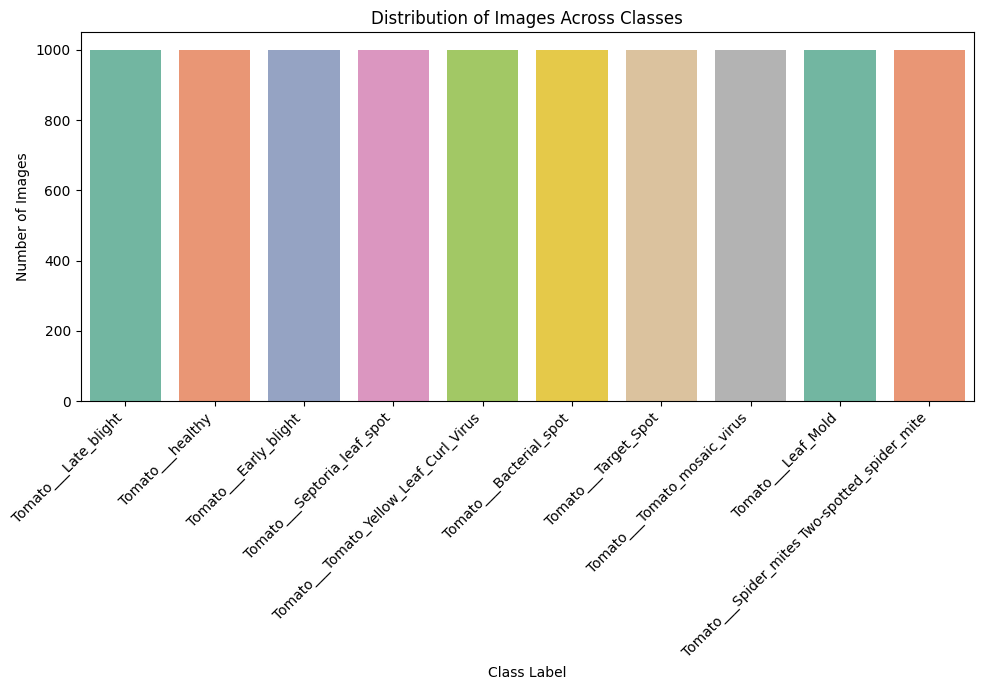

In [62]:
plt.figure(figsize=(10,7))
sns.countplot(data=train_df, x='class_label', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Images Across Classes')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

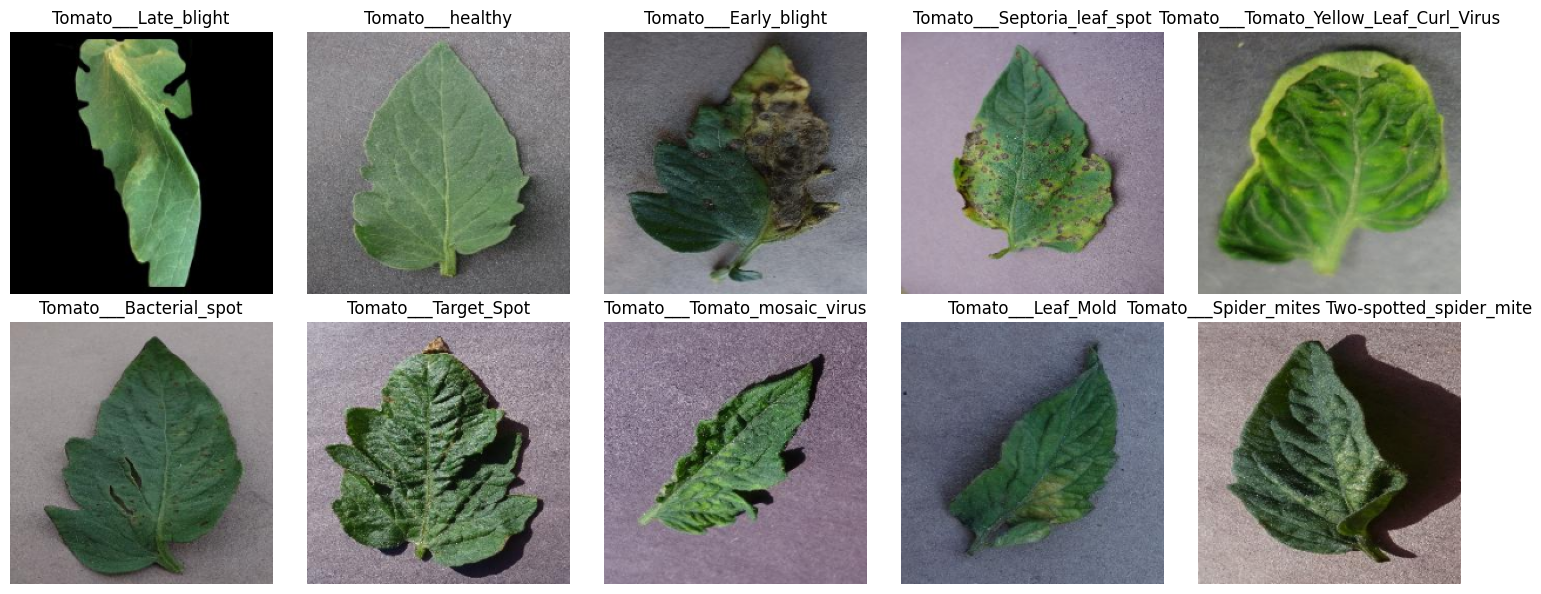

In [63]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, label in enumerate(labels):
    class_df = train_df[train_df['class_label'] == label]
    if class_df.empty:
        print(f"No images found for class label {label}. Skipping...")
        continue

    image_path = class_df.iloc[0]['image_path']
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image for class label {label} from {image_path}. Skipping...")
        continue

    img_resized = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img_rgb)
    axes[i].set_title(label)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [67]:
x_train, y_train = train
x_val, y_val = validation

In [68]:
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)

x_train shape: (10000, 224, 224, 3)
x_val shape: (1000, 224, 224, 3)


In [69]:
x_train

array([[[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
        

In [70]:
y_train

array([0, 0, 0, ..., 9, 9, 9])

In [71]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(x_train, y_train)
x_train = np.array(x_train)
y_train = np.array(y_train)

In [72]:
x_train = x_train.reshape(-1, img_size[0], img_size[1], 3)
x_val = x_val.reshape(-1, img_size[0], img_size[1], 3)

In [73]:
num_classes = len(labels)
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [74]:
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (10000, 224, 224, 3)
x_val shape: (1000, 224, 224, 3)
y_train shape: (10000, 10)
y_val shape: (1000, 10)


In [76]:
input_shape = (224, 224, 3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,278,858 (84.99 MB)

 Trainable params: 22,278,858 (84.99 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
history = model.fit(x_train, y_train, epochs = 10, verbose = 1, validation_data = (x_val, y_val))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.1710 - loss: 19.6495 - precision: 0.2387 - recall: 0.0286 - val_accuracy: 0.3340 - val_loss: 1.9402 - val_precision: 0.7545 - val_recall: 0.0830
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.2710 - loss: 2.0656 - precision: 0.5947 - recall: 0.0611 - val_accuracy: 0.3080 - val_loss: 1.9385 - val_precision: 0.7021 - val_recall: 0.0660
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.3496 - loss: 1.8854 - precision: 0.6326 - recall: 0.1268 - val_accuracy: 0.1980 - val_loss: 2.1653 - val_precision: 0.8889 - val_recall: 0.0080
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.2393 - loss: 2.1099 - precision: 0.5552 - recall: 0.0470 - val_accuracy: 0.2580 - val_loss: 2.0186 - val_precision: 0.7209 - val_recall: 0.0310
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.3446 - loss: 1.8615 - precision: 0.6359 - recall: 0.1259 - val_accuracy: 0.3650 - v

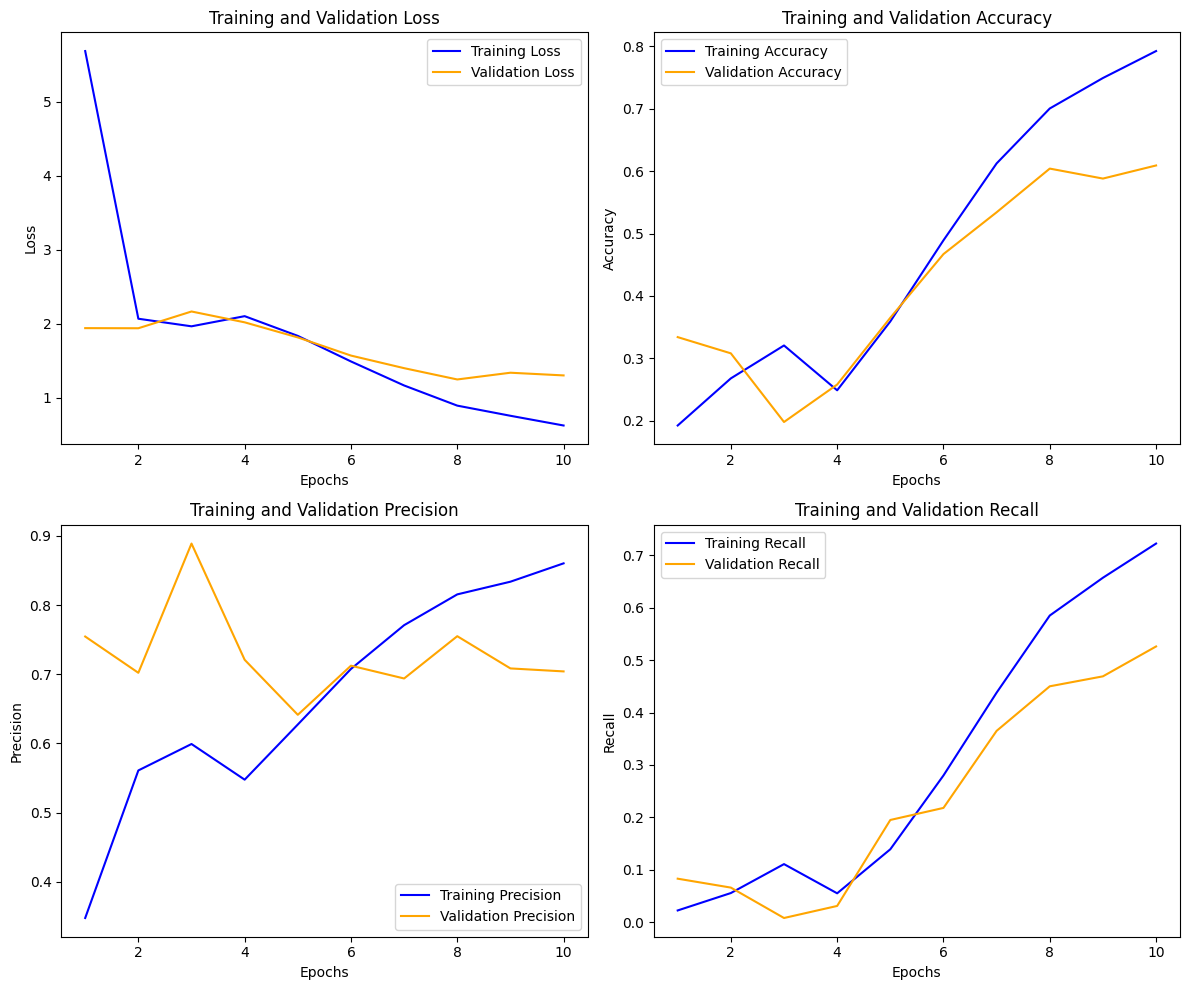

In [78]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
precision = history_dict['precision']
val_precision = history_dict['val_precision']
recall = history_dict['recall']
val_recall = history_dict['val_recall']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, precision, label='Training Precision', color='blue')
plt.plot(epochs, val_precision, label='Validation Precision', color='orange')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, recall, label='Training Recall', color='blue')
plt.plot(epochs, val_recall, label='Validation Recall', color='orange')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [84]:
input_shape = (224, 224, 3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 24, 24, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 10, 10, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 128)                 │         102,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 296,938 (1.13 MB)

 Trainable params: 296,938 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
history = model.fit(x_train, y_train, epochs = 10, verbose = 1, validation_data = (x_val, y_val))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.1036 - loss: 2.7769 - precision: 0.1870 - recall: 0.0080 - val_accuracy: 0.1510 - val_loss: 2.2820 - val_precision: 1.0000 - val_recall: 0.0040
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.1387 - loss: 2.2597 - precision: 0.7509 - recall: 0.0099 - val_accuracy: 0.2580 - val_loss: 2.0709 - val_precision: 0.6379 - val_recall: 0.0370
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.2917 - loss: 1.9858 - precision: 0.6673 - recall: 0.0626 - val_accuracy: 0.4350 - val_loss: 1.5811 - val_precision: 0.7353 - val_recall: 0.1000
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.4164 - loss: 1.6242 - precision: 0.6261 - recall: 0.1524 - val_accuracy: 0.6260 - val_loss: 1.1094 - val_precision: 0.7613 - val_recall: 0.4560
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.5760 - loss: 1.2155 - precision: 0.7333 - recall: 0.3915 - val_accuracy: 0.6560 - va

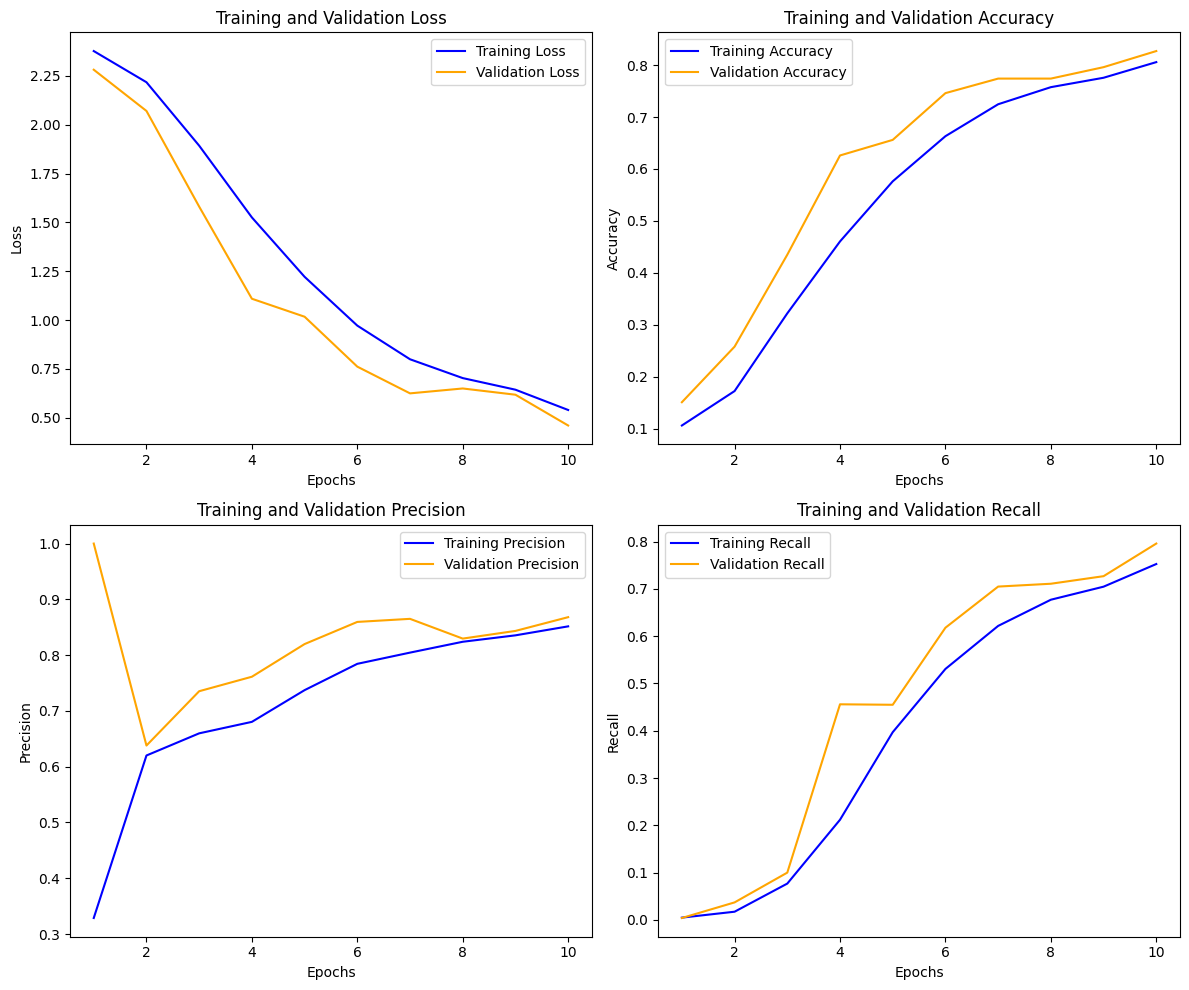

In [86]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
precision = history_dict['precision']
val_precision = history_dict['val_precision']
recall = history_dict['recall']
val_recall = history_dict['val_recall']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, precision, label='Training Precision', color='blue')
plt.plot(epochs, val_precision, label='Validation Precision', color='orange')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, recall, label='Training Recall', color='blue')
plt.plot(epochs, val_recall, label='Validation Recall', color='orange')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [97]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

model.summary()

Model: "functional_221"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_351 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_282   │ (None, 111, 111, 32)   │             96 │ conv2d_351[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_282            │ (None, 111, 111, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_352 (Conv2D)       │ (None, 109, 109, 32)   │          9,216 │ activation_282[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_283   │ (None, 109, 109, 32)   │             96 │ conv2d_352[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_283            │ (None, 109, 109, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_353 (Conv2D)       │ (None, 109, 109, 64)   │         18,432 │ activation_283[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_284   │ (None, 109, 109, 64)   │            192 │ conv2d_353[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_284            │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_76          │ (None, 54, 54, 64)     │              0 │ activation_284[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_354 (Conv2D)       │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_76[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 54, 54, 80)     │            240 │ conv2d_354[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_285            │ (None, 54, 54, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_355 (Conv2D)  

 Total params: 22,361,514 (85.30 MB)

 Trainable params: 558,730 (2.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [98]:
history = model.fit(x_train, y_train, epochs = 10, verbose = 1, validation_data = (x_val, y_val))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 128ms/step - accuracy: 0.1789 - loss: 6.0069 - precision: 0.2534 - recall: 0.0807 - val_accuracy: 0.2170 - val_loss: 2.1162 - val_precision: 0.7500 - val_recall: 0.0780
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.1759 - loss: 2.1434 - precision: 0.7102 - recall: 0.0596 - val_accuracy: 0.2200 - val_loss: 2.0453 - val_precision: 0.8317 - val_recall: 0.0840
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.1791 - loss: 2.1227 - precision: 0.7453 - recall: 0.0619 - val_accuracy: 0.1620 - val_loss: 2.1712 - val_precision: 1.0000 - val_recall: 0.0150
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.1706 - loss: 2.1569 - precision: 0.7129 - recall: 0.0496 - val_accuracy: 0.1910 - val_loss: 2.1122 - val_precision: 0.8750 - val_recall: 0.0490
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.1857 - loss: 2.1150 - precision: 0.6796 - recall: 0.0556 - val_accuracy: 0.2370 - v

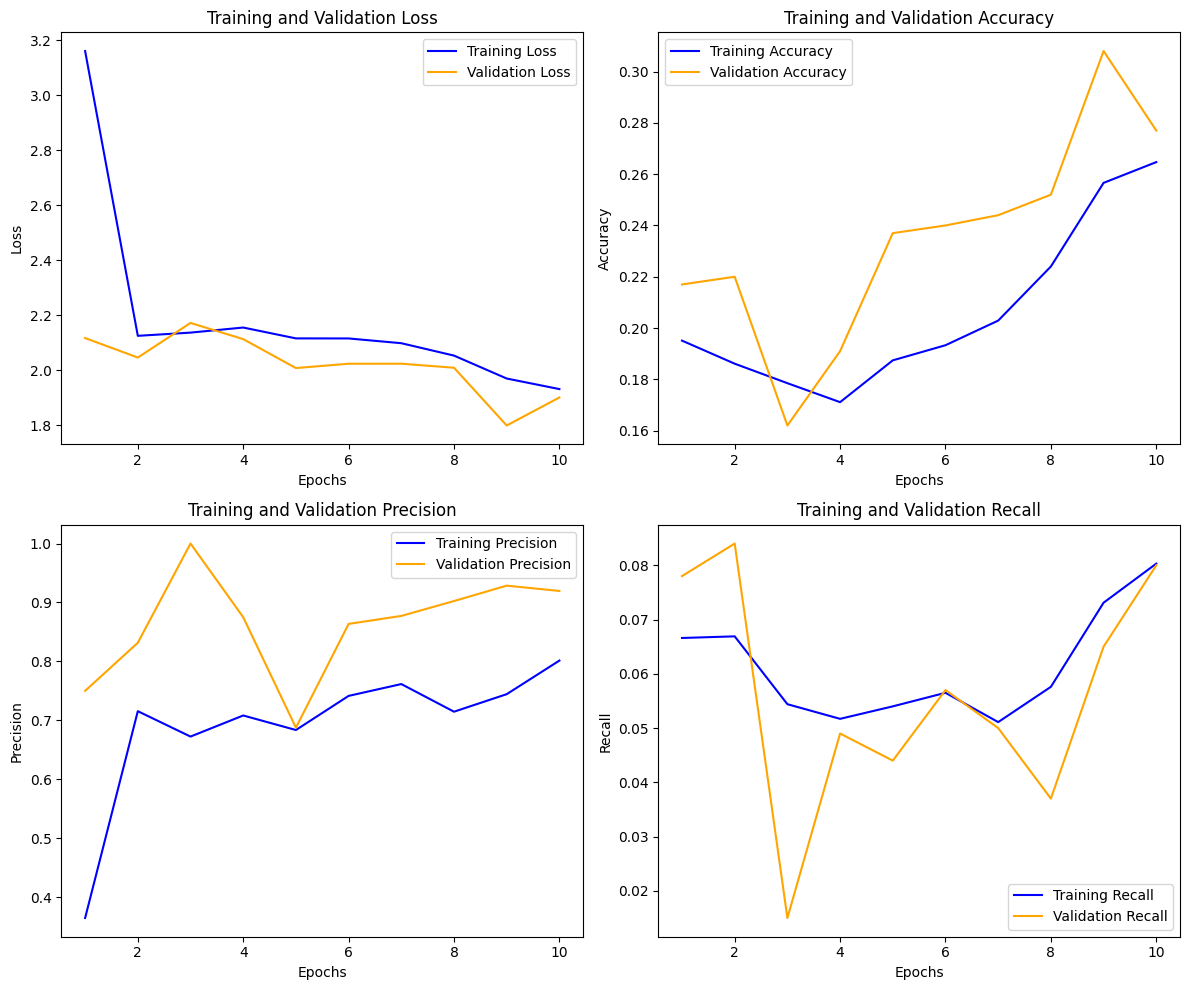

In [99]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
precision = history_dict['precision']
val_precision = history_dict['val_precision']
recall = history_dict['recall']
val_recall = history_dict['val_recall']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, precision, label='Training Precision', color='blue')
plt.plot(epochs, val_precision, label='Validation Precision', color='orange')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, recall, label='Training Recall', color='blue')
plt.plot(epochs, val_recall, label='Validation Recall', color='orange')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [101]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_222"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_19[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,334,090 (27.98 MB)

 Trainable params: 296,586 (1.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [102]:
history = model.fit(x_train, y_train, epochs = 10, verbose = 1, validation_data = (x_val, y_val))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 176ms/step - accuracy: 0.4270 - loss: 1.9740 - precision: 0.5940 - recall: 0.2532 - val_accuracy: 0.7590 - val_loss: 0.6903 - val_precision: 0.8617 - val_recall: 0.6540
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.7399 - loss: 0.7539 - precision: 0.8275 - recall: 0.6513 - val_accuracy: 0.8340 - val_loss: 0.5271 - val_precision: 0.8952 - val_recall: 0.7690
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.8050 - loss: 0.5762 - precision: 0.8659 - recall: 0.7444 - val_accuracy: 0.8290 - val_loss: 0.5472 - val_precision: 0.8825 - val_recall: 0.7810
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.8087 - loss: 0.5485 - precision: 0.8606 - recall: 0.7568 - val_accuracy: 0.8460 - val_loss: 0.5034 - val_precision: 0.8805 - val_recall: 0.8180
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.8362 - loss: 0.4839 - precision: 0.8772 - recall: 0.7898 - val_accuracy: 0.8640 - v

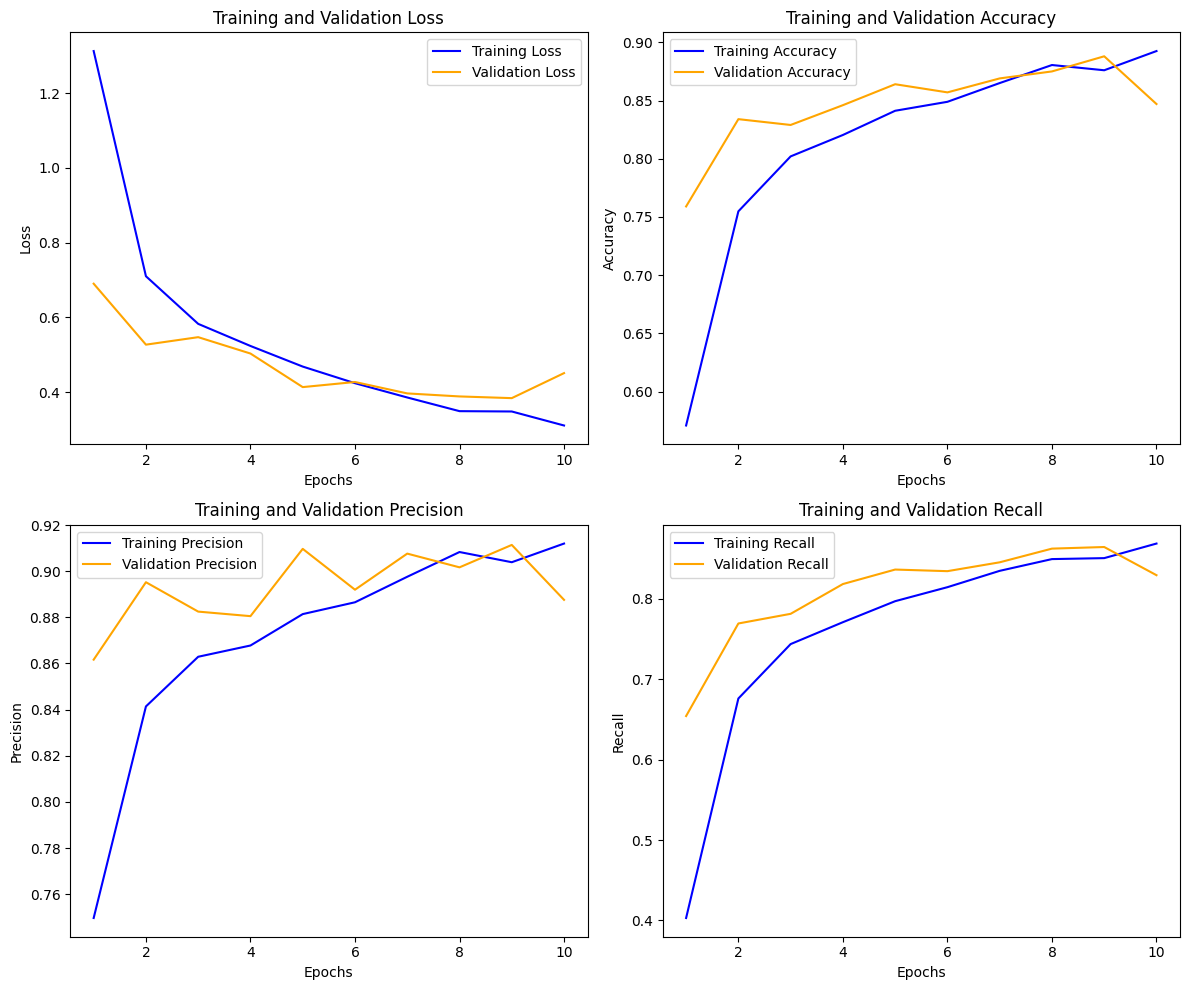

In [103]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
precision = history_dict['precision']
val_precision = history_dict['val_precision']
recall = history_dict['recall']
val_recall = history_dict['val_recall']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, precision, label='Training Precision', color='blue')
plt.plot(epochs, val_precision, label='Validation Precision', color='orange')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, recall, label='Training Recall', color='blue')
plt.plot(epochs, val_recall, label='Validation Recall', color='orange')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()